# Modélisation de nombre de demande

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tabulate import tabulate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pmdarima as pm
import pickle

In [2]:
df = pd.read_csv('energy_antananarivo_cleaned.csv', index_col='date', parse_dates=True)
df

,tot_nb_dmd,tot_energy
date,,
2000-01-01,1470,0.006076
2000-02-01,1519,0.006279
2000-03-01,1516,0.006266
2000-04-01,1499,0.006196
2000-05-01,1436,0.005935
...,...,...
2023-08-01,2913,0.022818
2023-09-01,2908,0.022779
2023-10-01,2824,0.022121


In [3]:
# Modification du type de l'objet object en datetime
# df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2000-01-01 to 2023-12-01
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tot_nb_dmd  288 non-null    int64  
 1   tot_energy  288 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 6.8 KB


In [4]:
df.describe()

,tot_nb_dmd,tot_energy
count,288.000000,288.000000
mean,2228.437500,0.013011
std,499.324467,0.004652
min,1228.000000,0.005076
25%,1820.500000,0.009145
50%,2220.500000,0.012636
75%,2660.250000,0.016511
max,3240.000000,0.025380


In [5]:
df = df.drop('tot_energy', axis=1)
# df.set_index('date', inplace=True)

In [6]:
# Vérification des valeurs manquantes
df.isnull().sum()

tot_nb_dmd    0
dtype: int64

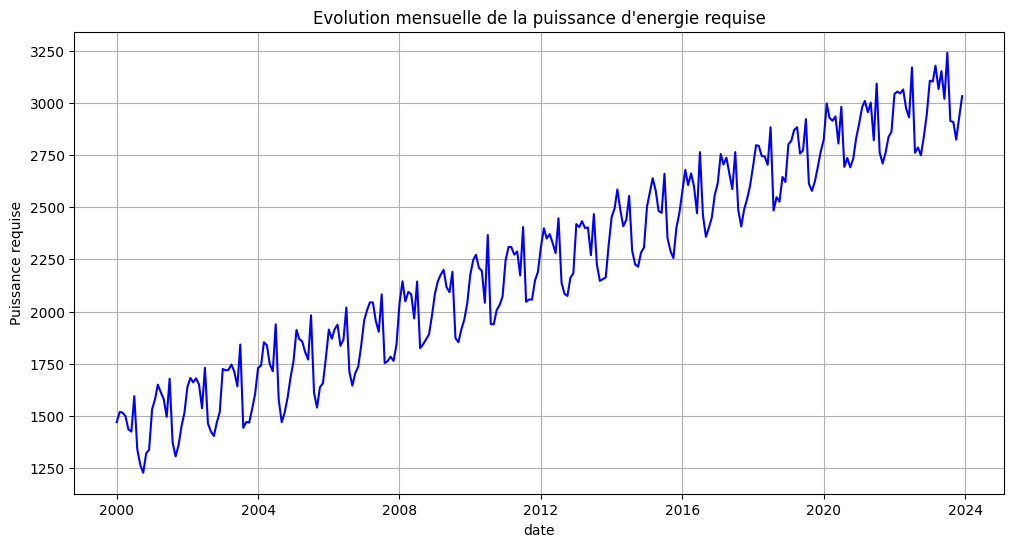

In [7]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['tot_nb_dmd'], color='blue')
plt.title('Evolution mensuelle de la puissance d\'energie requise')
plt.xlabel('date')
plt.ylabel('Puissance requise')
plt.grid(True)
plt.show()

## Stationnarité de données

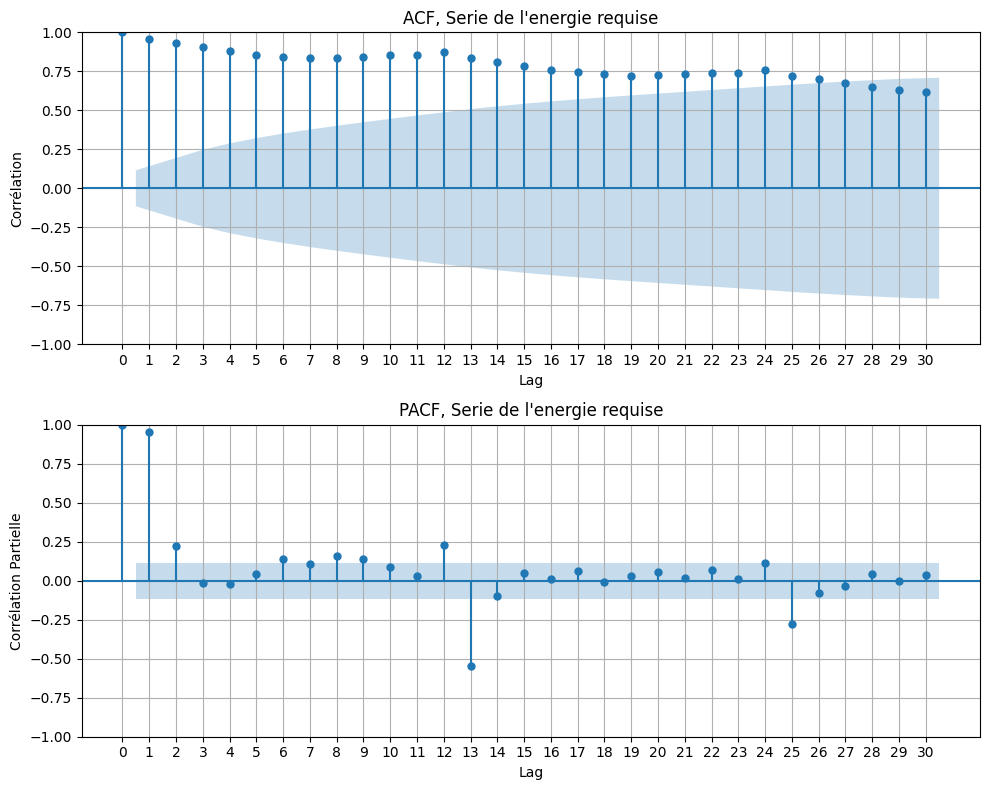

In [8]:
# Création des subplots 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8))

# Traçage l'ACF
plot_acf(df['tot_nb_dmd'], lags=30, zero=True, ax=ax1)
ax1.set_title('ACF, Serie de l\'energie requise')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

# Ajustement des graduations sur l'axe x pour l'ACF
ax1.set_xticks(np.arange(0,31,1))

# Traçage PACF
plot_pacf(df['tot_nb_dmd'], lags=30, zero=True, ax=ax2)
ax2.set_title('PACF, Serie de l\'energie requise')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation Partielle')
ax2.grid(True)

# Ajustement les graduations sur l'axe x pour le PACF
ax2.set_xticks(np.arange(0,31,1))

# Ajustement les subplots
plt.tight_layout()

plt.show()

In [9]:
# Test de Dickey-Fuller augmenté
result = adfuller(df)

# Formater les résultats dans un tableau
table = [
    ['Valeur de test', result[0]],
    ['P-valeur', result[1]],
    ['Conclusion', 'La série est stationnaire' if result[1] < 0.05 else 'La serie est non stationnaire']
]

print(tabulate(table, headers=['Metrique', 'Valeur'], tablefmt='github'))

| Metrique       | Valeur                        |
|----------------|-------------------------------|
| Valeur de test | -0.2619430649253822           |
| P-valeur       | 0.9307240618890655            |
| Conclusion     | La serie est non stationnaire |


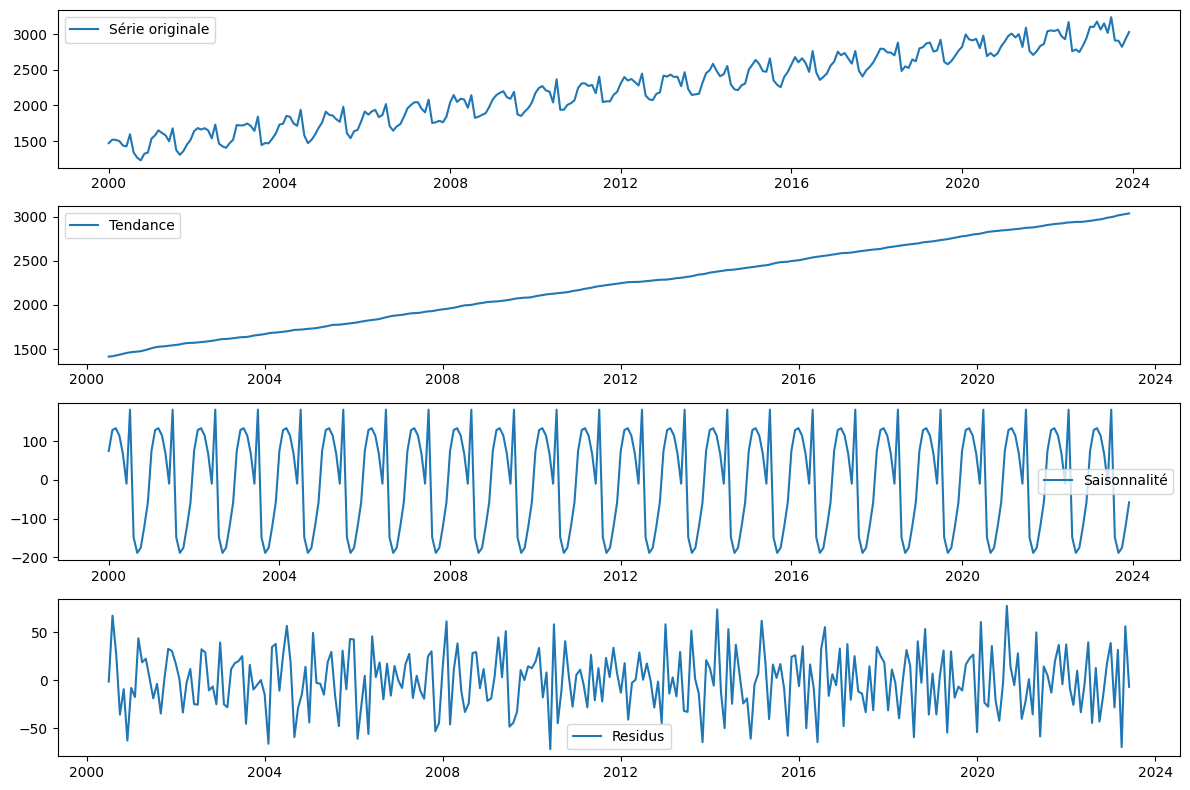

In [10]:
# Decompostion saisonnière
decomposition = seasonal_decompose(df['tot_nb_dmd'], model='additive')

# Extraction des composantes de la decomposotion
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Affichage des composantes de la décomposition
plt.figure(figsize=(12,8))

plt.subplot(411)
plt.plot(df['tot_nb_dmd'], label='Série originale')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendance')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Saisonnalité')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residus')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

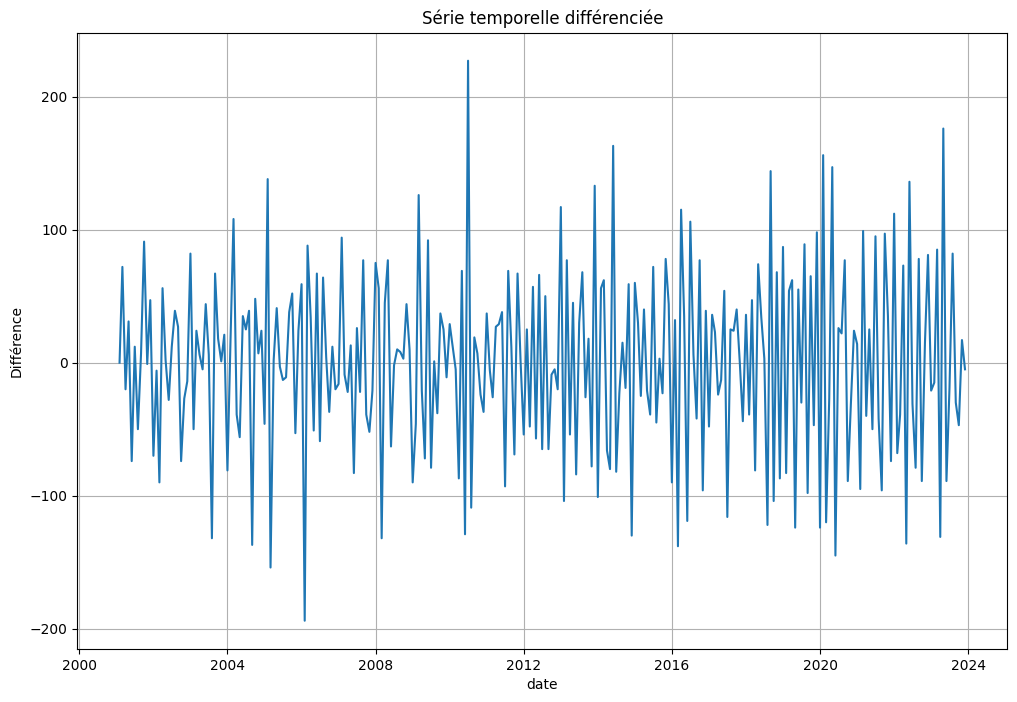

In [11]:
## Différenciation de données
differenced = df['tot_nb_dmd'].diff().dropna()

# Differenciation saisonnière 
differenced = differenced.diff(12).dropna()

# Afficher la série différenciée
plt.figure(figsize=(12,8))
plt.plot(differenced)
plt.title('Série temporelle différenciée')
plt.xlabel('date')
plt.ylabel('Différence')
plt.grid(True)
plt.show()

In [12]:
# Test de Dickey-Fuller augmenté
result = adfuller(differenced)

# Formater les résultats dans un tableau
table = [
    ['Valeur de test', result[0]],
    ['P-valeur', result[1]],
    ['Conclusion', 'La série est stationnaire' if result[1] < 0.05 else 'La serie est non stationnaire']
]

print(tabulate(table, headers=['Metrique', 'Valeur'], tablefmt='github'))

| Metrique       | Valeur                    |
|----------------|---------------------------|
| Valeur de test | -6.860058542454596        |
| P-valeur       | 1.6110612973865365e-09    |
| Conclusion     | La série est stationnaire |


In [13]:
# Utilisation de l'auto_arima pour trouver le meilleur modèle ARIMA
train = differenced[:-15]
test = differenced[-15:]

modèle optimal: SARIMAX(5, 0, 0)x(2, 0, 0, 12)

In [14]:
model = sm.tsa.statespace.SARIMAX(train, order=(5,0,0), seasonal_order=(2, 0, [1], 12))
model = model.fit()

/home/anthony/PycharmProjects/DL/Memoire INSI/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/anthony/PycharmProjects/DL/Memoire INSI/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14682D+00    |proj g|=  6.99496D-02

At iterate    5    f=  5.11286D+00    |proj g|=  5.98549D-02

At iterate   10    f=  5.09835D+00    |proj g|=  9.07253D-03

At iterate   15    f=  5.03546D+00    |proj g|=  7.85901D-02

At iterate   20    f=  5.02999D+00    |proj g|=  7.33317D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     22     26      1     0     0   8.303D-06   5.030D+00
  F =   5.0299883451183032     

CONVERG

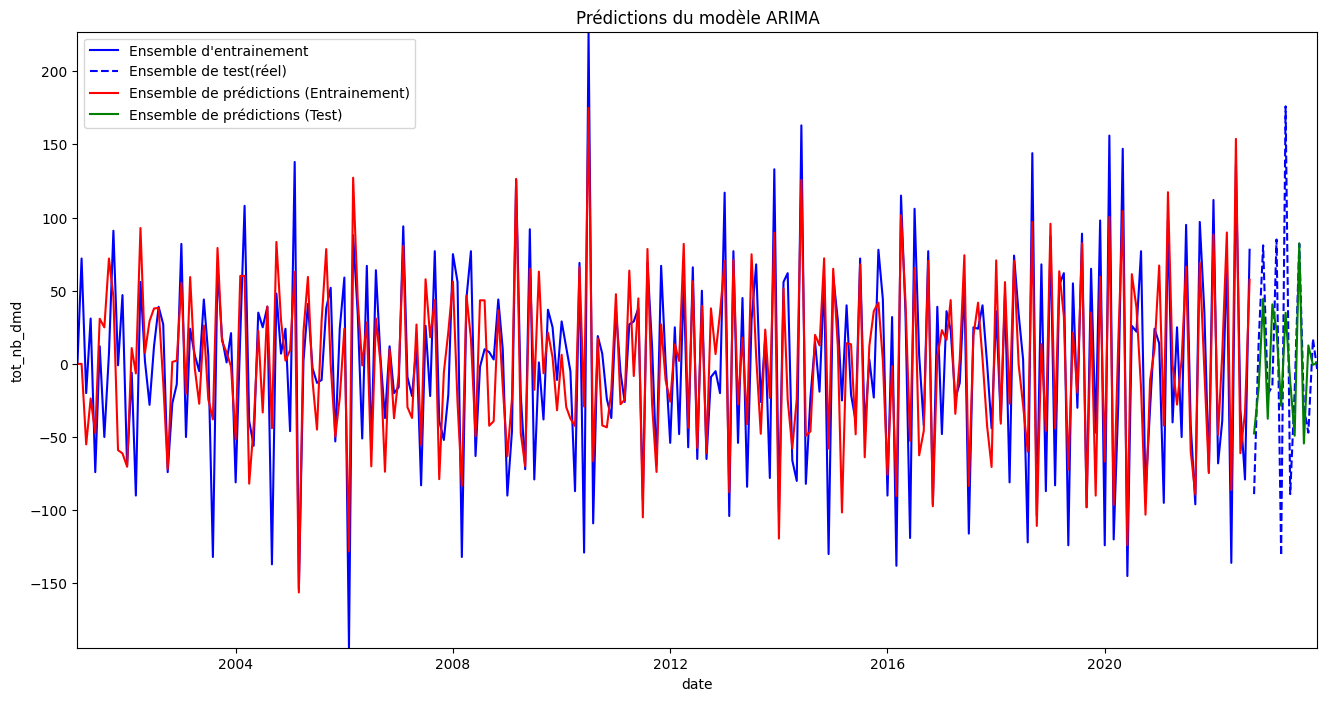

In [15]:
# Prédiction sur l'ensemble d'entrainement
train_prediction = model.predict(start=train.index[0], end=train.index[-1])

# Prédiction sur l'ensemble de test
test_prediction = model.predict(start=test.index[0], end=test.index[-1])

# Traçage des predictions et les données réels avec les courbes collées.
plt.figure(figsize=(16,8))
plt.plot(train.index, train.values, label='Ensemble d\'entrainement', color='blue')
plt.plot(test.index, test.values, label='Ensemble de test(réel)', linestyle='--', color='blue')
plt.plot(train_prediction.index, train_prediction.values, label='Ensemble de prédictions (Entrainement)', color='red')
plt.plot(test_prediction.index, test_prediction.values, label='Ensemble de prédictions (Test)', color='green')

# Définition des limites des axes x et y pour une continuté visuelle.
plt.xlim(train.index[0], test.index[-1])
plt.ylim(min(train.min(), test.min()), max(train.max(), test.max()))

plt.xlabel('date')
plt.ylabel('tot_nb_dmd')
plt.title('Prédictions du modèle ARIMA')
plt.legend()
plt.show()

In [16]:
predictions = model.predict(start=test.index[0], end=test.index[-1])

# Mesures de performances sur l'ensemble de test
test_mae = mean_absolute_error(test, predictions)
test_mse = mean_squared_error(test, predictions)
test_rmse = mean_squared_error(test, predictions, squared=False)
test_r2 = r2_score(test, predictions)

# Création d'un Dataframe pour afficher les mesures de performance
perf_df = pd.DataFrame({
    'Métriques:': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Ensemble de test:': [test_mae, test_mse, test_rmse, test_r2]
})

perf_df

/home/anthony/PycharmProjects/DL/Memoire INSI/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Métriques:,Ensemble de test:
0,MAE,46.784312
1,MSE,3528.068908
2,RMSE,59.397550
3,R²,0.406431


In [17]:
model_sarima = SARIMAX(train, order=(5, 0, 0), seasonal_order=(2, 0, [1], 12))
model_sarima_fit = model_sarima.fit()

/home/anthony/PycharmProjects/DL/Memoire INSI/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/anthony/PycharmProjects/DL/Memoire INSI/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14682D+00    |proj g|=  6.99496D-02



At iterate    5    f=  5.11286D+00    |proj g|=  5.98549D-02

At iterate   10    f=  5.09835D+00    |proj g|=  9.07253D-03

At iterate   15    f=  5.03546D+00    |proj g|=  7.85901D-02

At iterate   20    f=  5.02999D+00    |proj g|=  7.33317D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     22     26      1     0     0   8.303D-06   5.030D+00
  F =   5.0299883451183032     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [18]:
predictions = model_sarima_fit.predict(start=test.index[0], end=test.index[-1])

# Mesures de performances sur l'ensemble de test
test_mae = mean_absolute_error(test, predictions)
test_mse = mean_squared_error(test, predictions)
test_rmse = mean_squared_error(test, predictions, squared=False)
test_r2 = r2_score(test, predictions)

# Création d'un Dataframe pour afficher les mesures de performance
perf_df = pd.DataFrame({
    'Métriques:': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Ensemble de test:': [test_mae, test_mse, test_rmse, test_r2]
})

perf_df

/home/anthony/PycharmProjects/DL/Memoire INSI/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Métriques:,Ensemble de test:
0,MAE,46.784312
1,MSE,3528.068908
2,RMSE,59.397550
3,R²,0.406431


In [19]:
# Entrainement avec tout l'ensemble de données
model_sarima = SARIMAX(df, order=(5, 0, 0), seasonal_order=(2, 0, [1], 12), enforce_stationarity=False, trend='c', enforce_invertibility=False)
model_sarima_fit = model_sarima.fit()

/home/anthony/PycharmProjects/DL/Memoire INSI/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/anthony/PycharmProjects/DL/Memoire INSI/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93399D+00    |proj g|=  1.07266D+01

At iterate    5    f=  5.32161D+00    |proj g|=  7.09266D-01

At iterate   10    f=  5.28275D+00    |proj g|=  2.98587D-01

At iterate   15    f=  5.26045D+00    |proj g|=  7.11413D-01

At iterate   20    f=  5.23804D+00    |proj g|=  2.53733D-01

At iterate   25    f=  5.23299D+00    |proj g|=  2.99408D-01

At iterate   30    f=  5.22848D+00    |proj g|=  2.83794D-01

At iterate   35    f=  5.22588D+00    |proj g|=  2.23897D-01

At iterate   40    f=  5.22561D+00    |proj g|=  6.01039D-02

At iterate   45    f=  5.22529D+00    |proj g|=  4.13777D-01

At iterate   50    f=  5.22439D+00    |proj g|=  5.36362D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/anthony/PycharmProjects/DL/Memoire INSI/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
predictions = model_sarima_fit.forecast(15)
predictions

2024-01-01    3173.635930
2024-02-01    3186.059799
2024-03-01    3219.767851
2024-04-01    3172.700691
2024-05-01    3182.893930
2024-06-01    3077.523836
2024-07-01    3310.769405
2024-08-01    2952.163808
2024-09-01    2954.701637
2024-10-01    2905.656897
2024-11-01    3001.657702
2024-12-01    3095.217312
2025-01-01    3246.424932
2025-02-01    3256.137704
2025-03-01    3300.416088
Freq: MS, Name: predicted_mean, dtype: float64

In [21]:
# Enregistrement de la fonction dans un fichier pickle
with open('demande_fit.pkl', 'wb') as pkl_file:
    pickle.dump(model_sarima_fit, pkl_file)

In [23]:
df.tail()

,tot_nb_dmd
date,
2023-08-01,2913
2023-09-01,2908
2023-10-01,2824
2023-11-01,2932
2023-12-01,3032
